In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from pydicom import dcmread
%matplotlib inline
tf.__version__

import sys
print(sys.version)
print(sys.executable)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
C:\ProgramData\Anaconda3\python.exe


In [2]:
#draw images
from datetime import datetime
def drawCategorizedImages(folderPath, dict, fontsize=10, fontfamily='MingLiU'):
    for patient in dict:
        for study in dict[patient]:
            for series in dict[patient][study]:
                fileList = dict[patient][study][series]
                imagesList = []
                for file in fileList:
                    imagesList.append(dcmread(folderPath + file))
                imagesList.sort(key=lambda x: x.InstanceNumber, reverse=False) # sort image by instance number
                quantity = len(imagesList)
                cols = 10
                rows = math.ceil(quantity/cols)
                rows = rows + int(rows/6) + 1 # add blank rows to place text
                fig = plt.figure(figsize=(cols*2,rows*2))
                flag = True
                for i in range(quantity):
                    ds = imagesList[i]

                    if ("PixelData" in ds):
                        #add text only once
                        if flag:
                            plt.text(0.01,0.135,"PatientName: " + str(ds.PatientName), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.01,0.11,"PatientID: " + str(ds.PatientID), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.01,0.085,"Sex: " + str(ds.PatientSex), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.135,"InstitutionName: " + ds.InstitutionName if ds.InstitutionName != "" else "InstitutionName: None", fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.11,"StudyDescription: " + ds.StudyDescription, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.085,"StudyID: " + ds.StudyID, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.06,"AccessionNumber: " + ds.AccessionNumber, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.035,"AcquisitionDate: " + str(datetime.strptime(ds.AcquisitionDate, '%Y%m%d').date()), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.33,0.01,"AcquisitionTime: " + ds.AcquisitionTime, fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.66,0.135,"SeriesNumber: " + str(ds.SeriesNumber), fontsize=fontsize, fontfamily=fontfamily)
                            plt.text(0.66,0.11,"SeriesDescription: " + str(ds.SeriesDescription), fontsize=fontsize, fontfamily=fontfamily)
#                             plt.text(0.66,0.085,"SliceThickness: " + str(math.ceil(ds.SliceThickness)) + "mm", fontsize=fontsize, fontfamily=fontfamily)
#                             plt.text(0.66,0.06,"SliceLocation: " + str(math.ceil(ds.SliceLocation)) + "mm", fontsize=fontsize, fontfamily=fontfamily)
                            flag = False   

                        fig.add_subplot(rows, cols, i+1)
                        plt.imshow(ds.pixel_array, cmap='gray')
                        plt.axis('off')

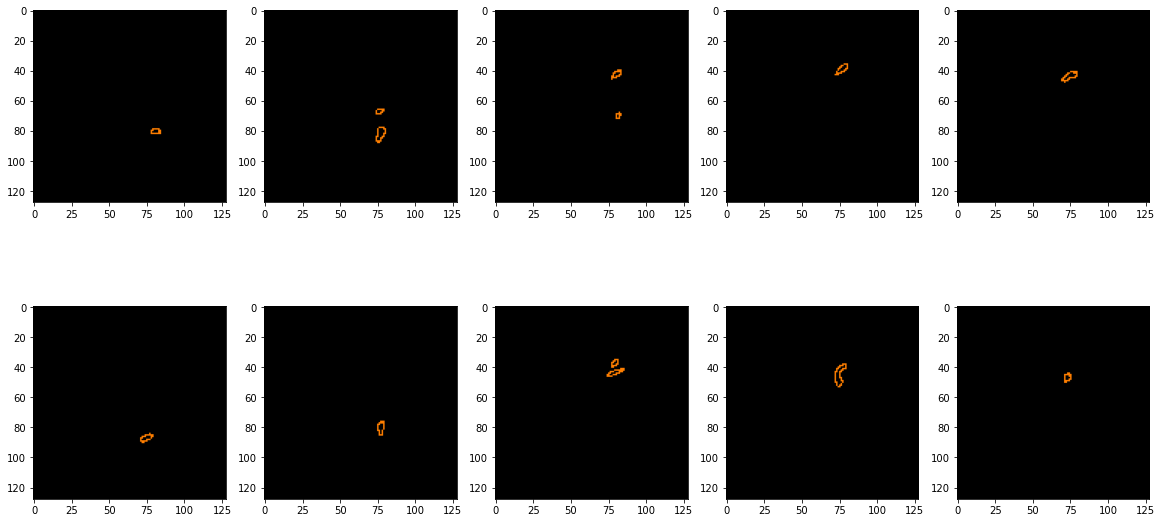

In [3]:
#draw lines with pillow and add images to list
import math
from PIL import Image, ImageDraw
import json
import glob
jsonFiles = glob.glob("001/*.json")
images = []
for i in jsonFiles:    
    file = open(i)
    data = json.load(file)
    im = Image.new("RGB", data['size'])
    draw = ImageDraw.Draw(im)
    shapes = data['shapes']
    for shape in shapes:
        segments = shape['segments']
        strokeColor = shape['strokeColor']
        for segment in segments:
            startEndCoord = [(segment['a'][0], segment['a'][1]),(segment['b'][0], segment['b'][1])]
            draw.line(startEndCoord, fill=strokeColor)
    images.append(im)

#show images with pyplot
quantity = len(images)
cols = 5
rows = math.ceil(quantity/cols)
fig,ax = plt.subplots(rows,cols,figsize=(20,10))
for i in range(len(images)):
    ax[i%rows][i//rows].imshow(images[i])

In [4]:
#find images file name by SeriesNumber to be drawn
from pydicom.fileset import FileSet
dicomdir = dcmread("002/dicomdir")
fs = FileSet(dicomdir)
print(fs)

DICOM File-set
  Root directory: C:\Users\Justin\Desktop\MRI\002
  File-set ID: 20220602091300
  File-set UID: 1.2.840.113820.4100.20220602091300.194973
  Descriptor file ID: (no value available)
  Descriptor file character set: (no value available)
  Changes staged for write(): DICOMDIR update, directory structure update

  Managed instances:
    PATIENT: PatientID='ID20220602091257', PatientName='Demo'
      STUDY: StudyDate=20220208, StudyTime=154719, StudyDescription='MRI, Brain with contrast'
        SERIES: Modality=PR, SeriesNumber=0
          PRESENTATION: 1 SOP Instance
        SERIES: Modality=PR, SeriesNumber=0
          PRESENTATION: 1 SOP Instance
        SERIES: Modality=PR, SeriesNumber=0
          PRESENTATION: 1 SOP Instance
        SERIES: Modality=PR, SeriesNumber=0
          PRESENTATION: 1 SOP Instance
        SERIES: Modality=PR, SeriesNumber=0
          PRESENTATION: 1 SOP Instance
        SERIES: Modality=PR, SeriesNumber=0
          PRESENTATION: 1 SOP Instance

In [5]:
#categorize dicom files with patientID, studyID and seriesID using dicomdir
dict = {}
patientIDs = fs.find_values("PatientID")
for patientID in patientIDs:
    instances = fs.find(PatientID=patientID)
    for ds in instances:
        patientID = ds.PatientID
        studyID = ds.StudyID
        seriesID = ds.SeriesNumber
        fileName = ds.ReferencedFileID
        if patientID in dict:
            if studyID in dict[patientID]:
                if seriesID in dict[patientID][studyID]:
                    dict[patientID][studyID][seriesID].append(fileName)
                else:
                    dict[patientID][studyID][seriesID] = [fileName]
            else:
                dict[patientID][studyID] = {seriesID:[fileName]}
        else:
            dict[patientID] = {studyID:{seriesID:[fileName]}}

<Figure size 1440x432 with 0 Axes>

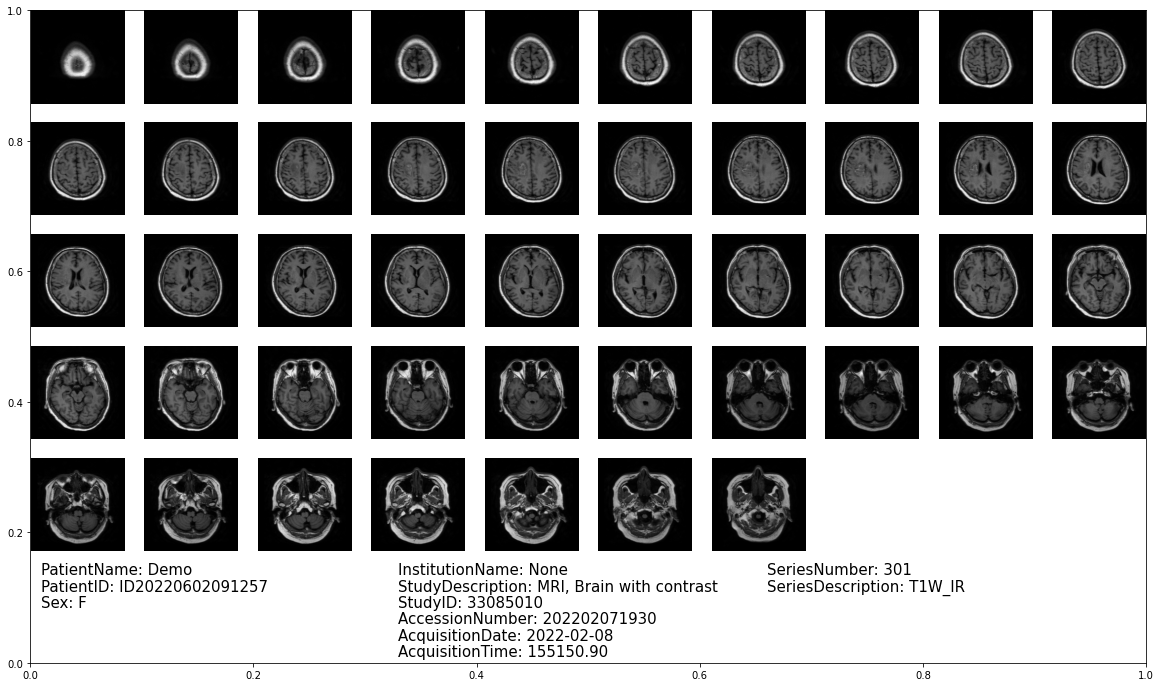

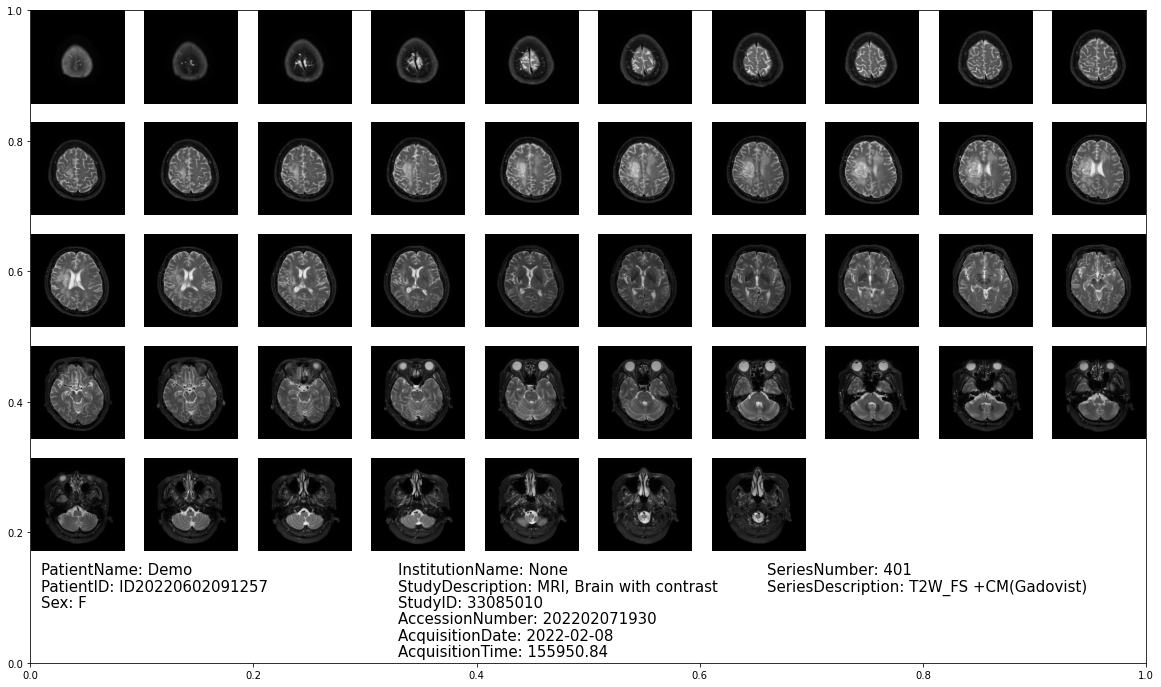

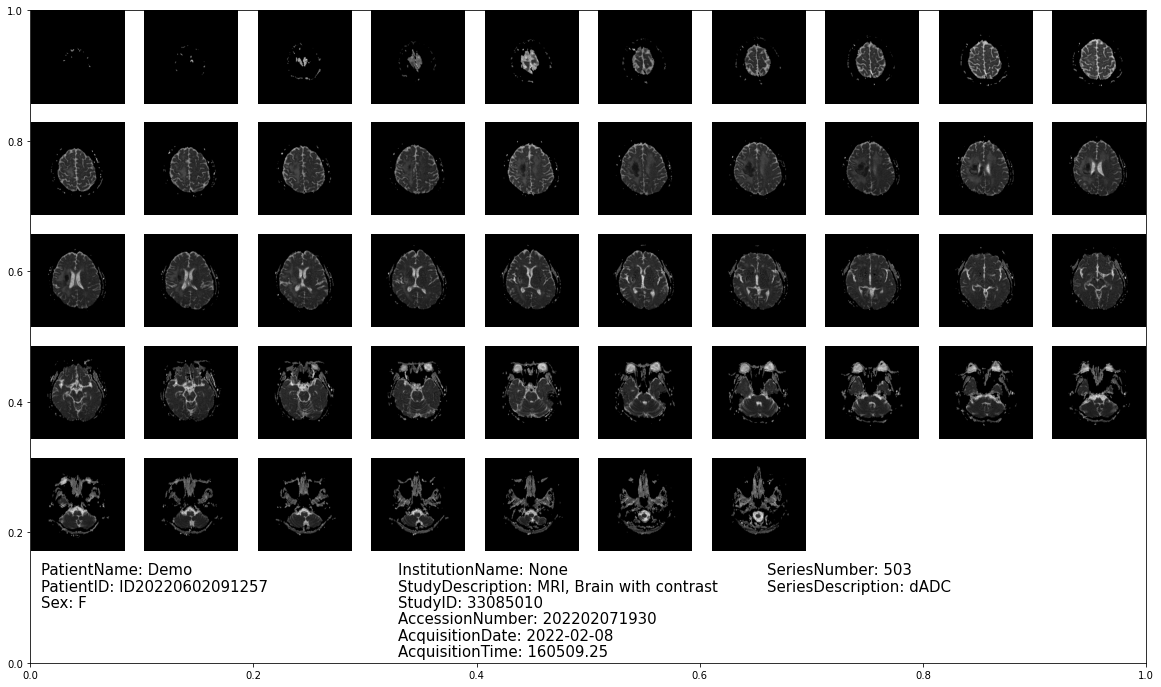

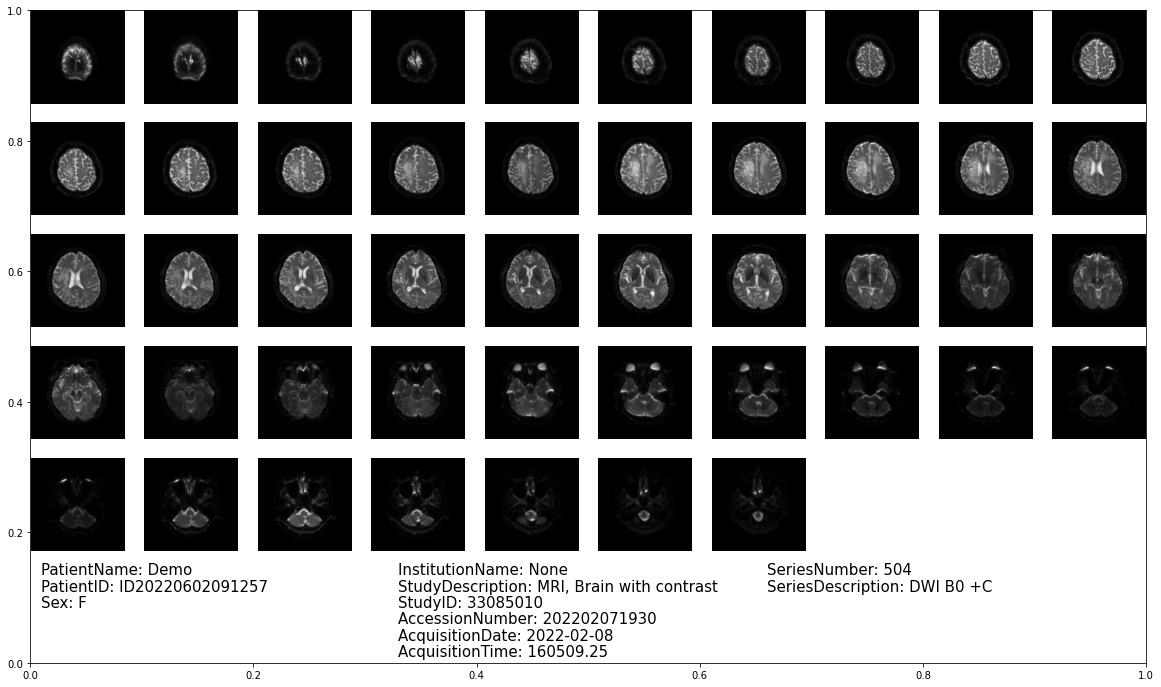

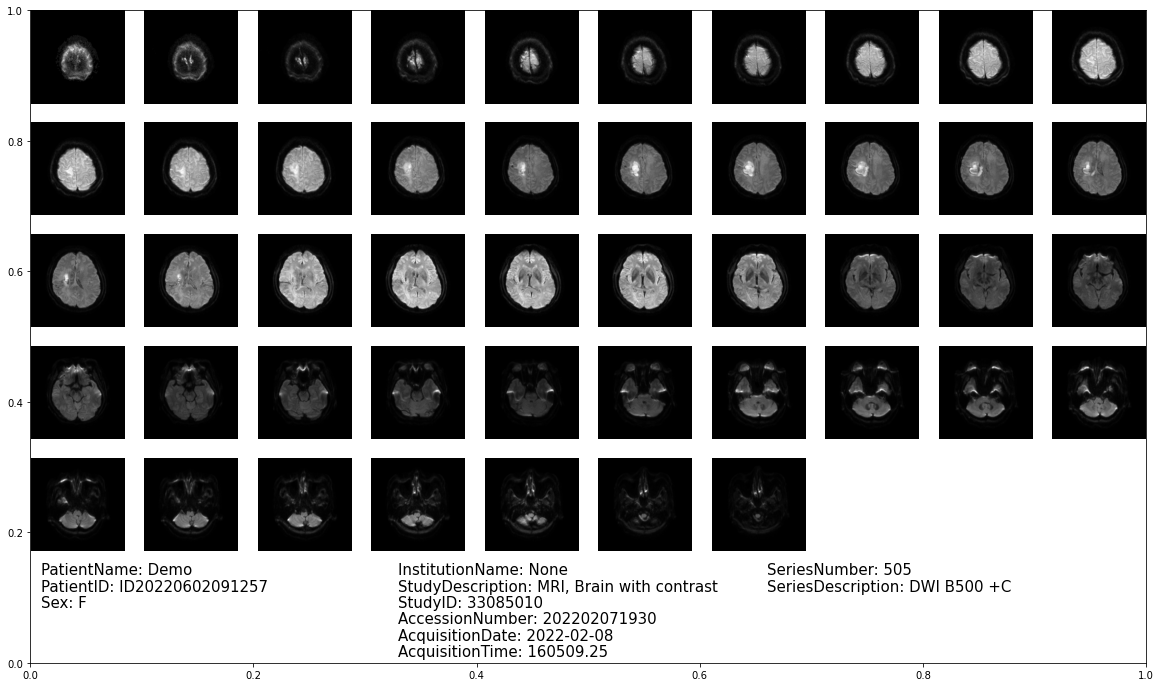

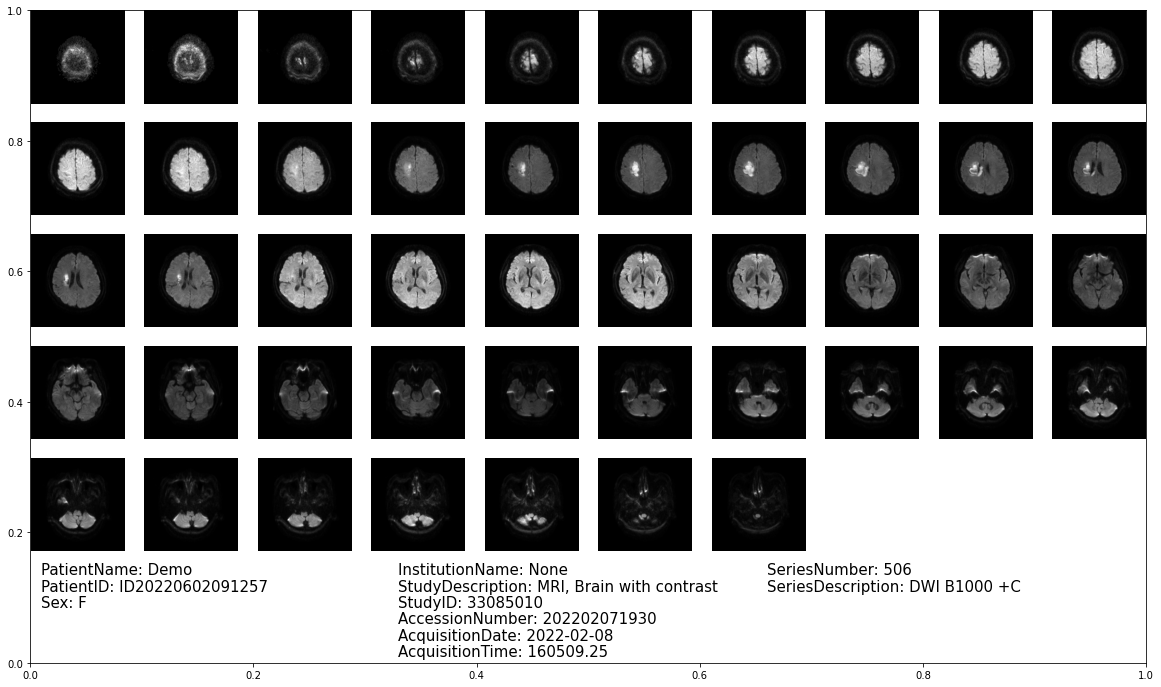

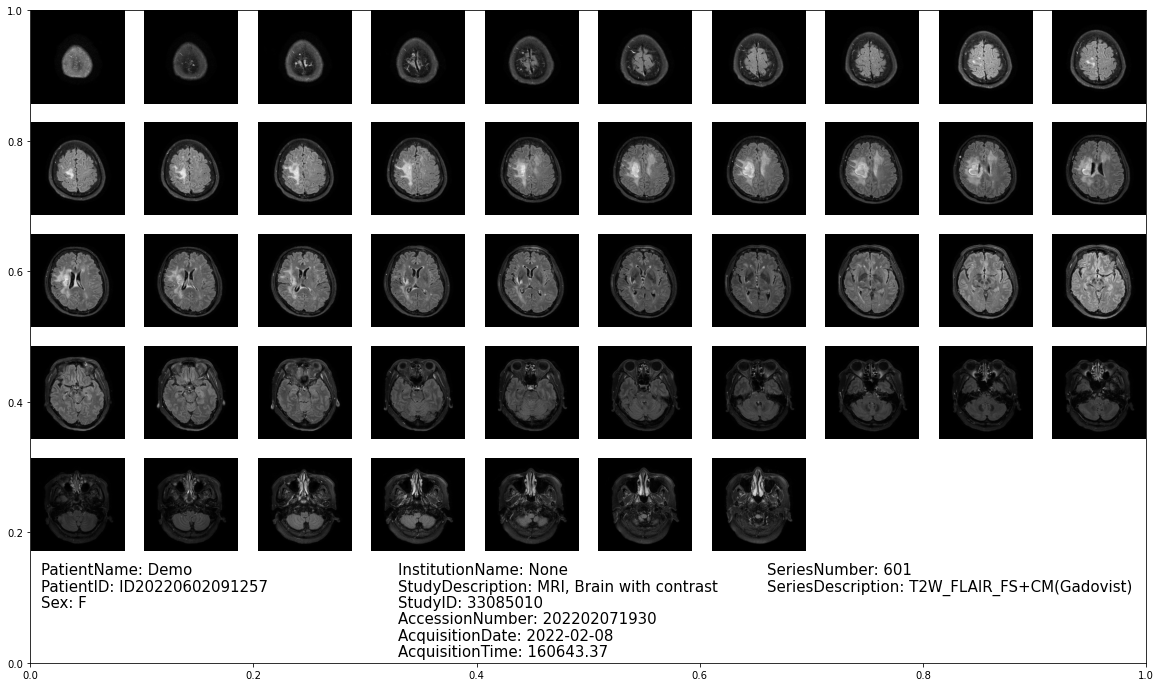

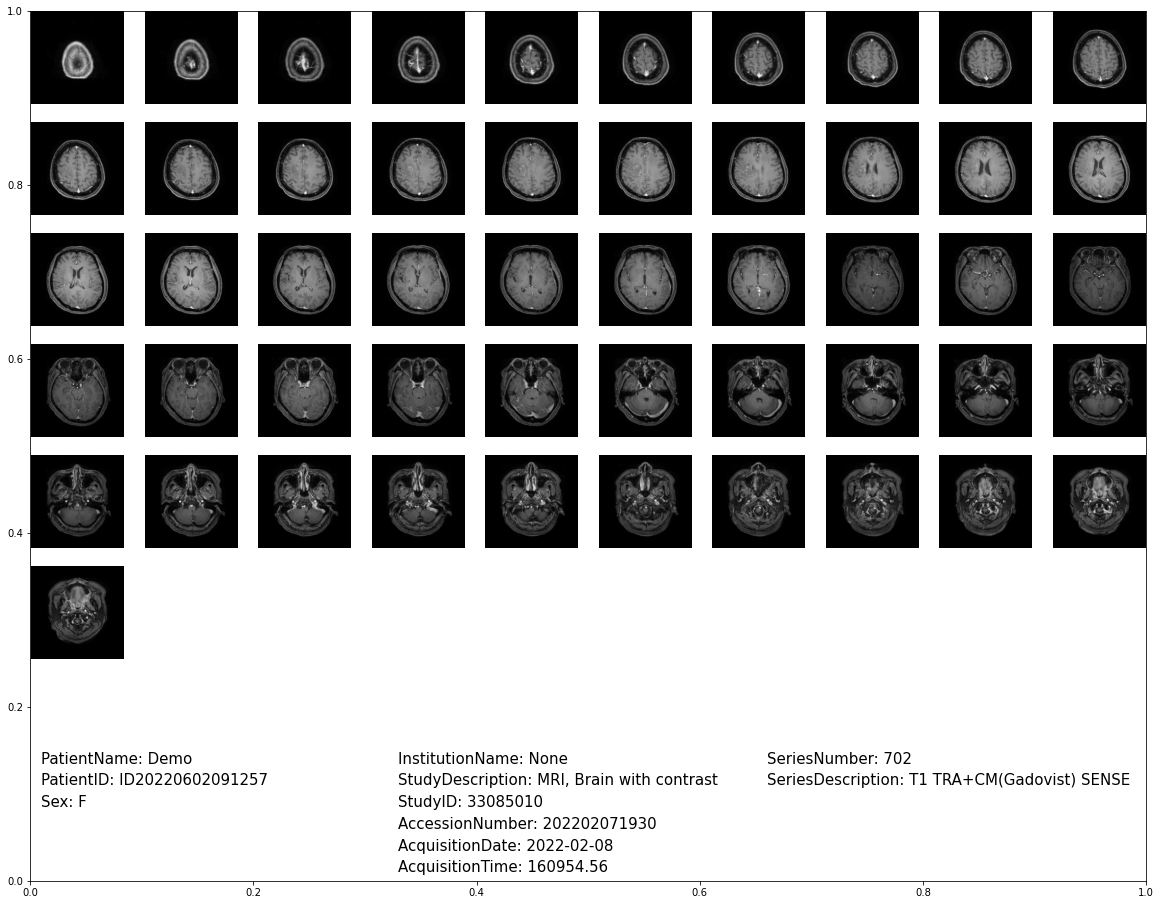

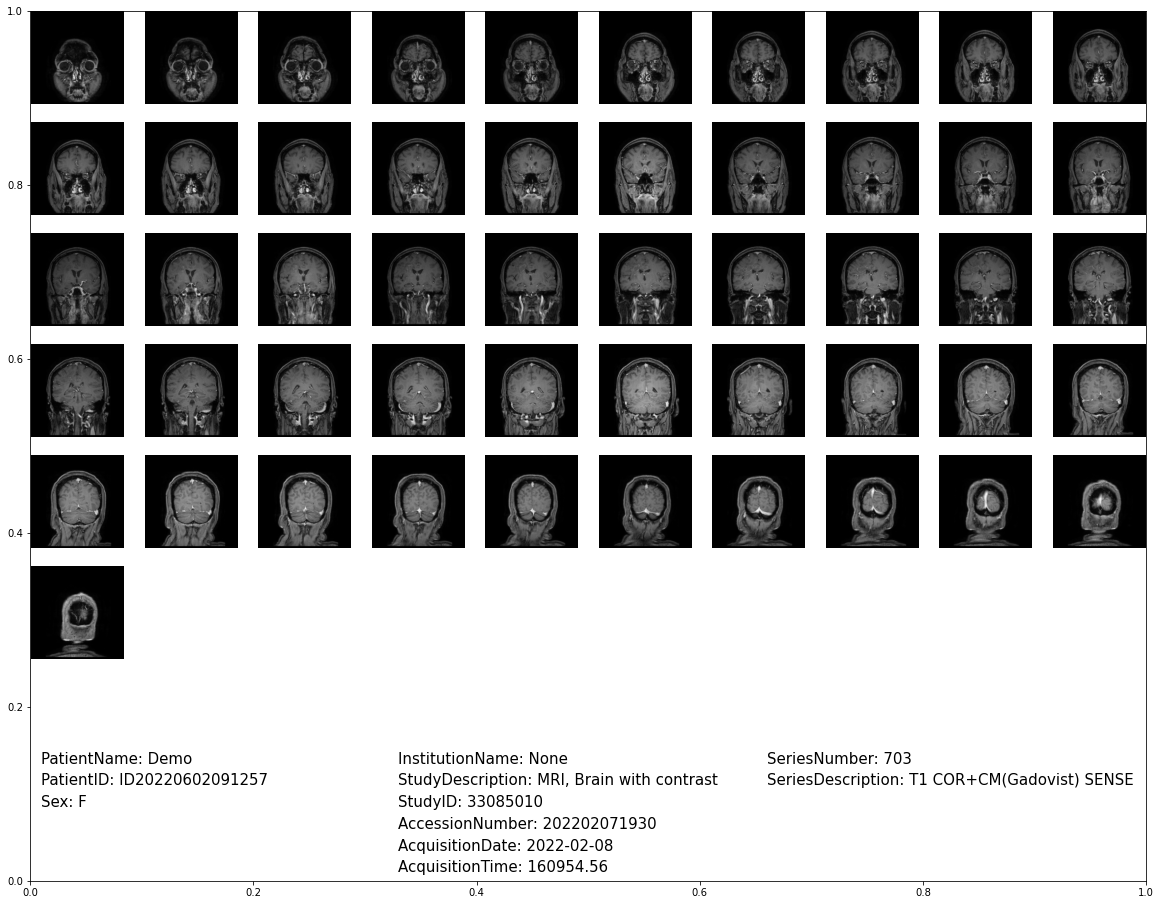

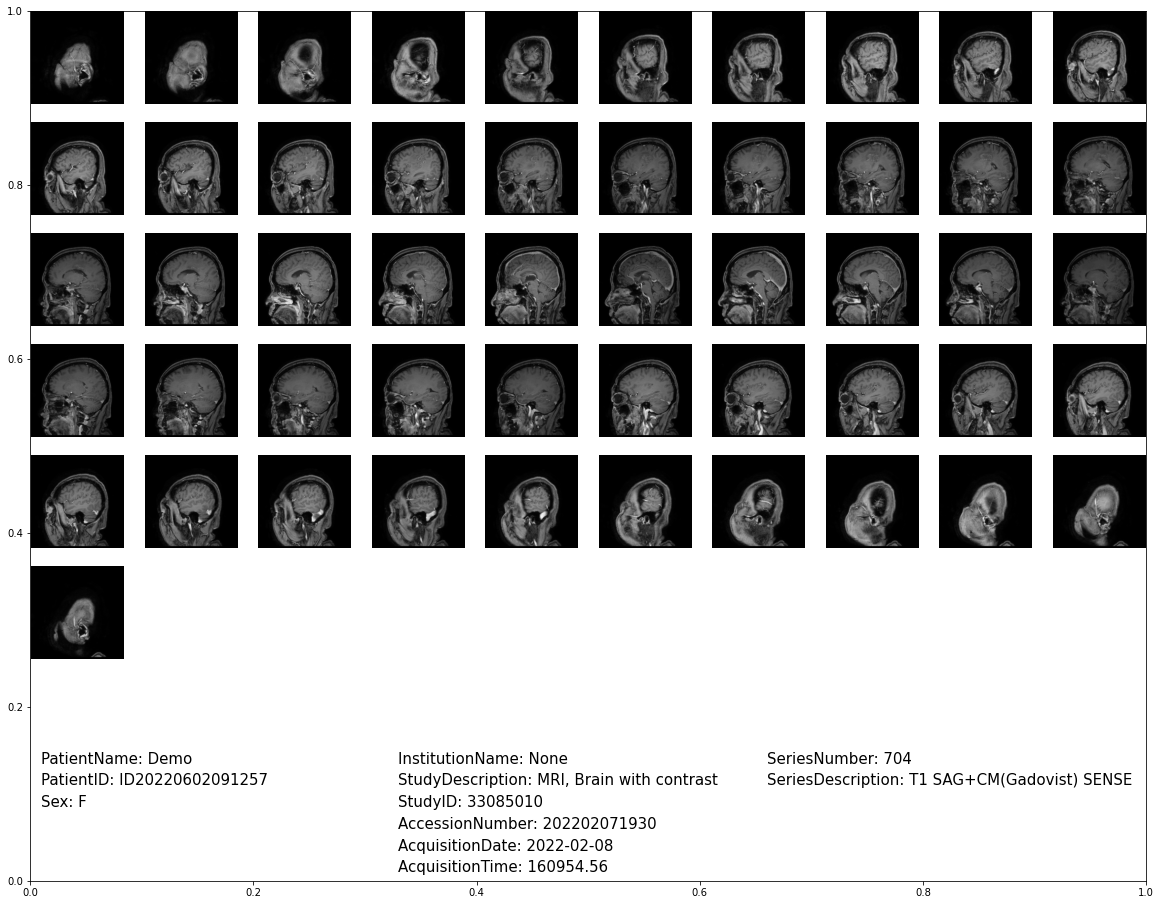

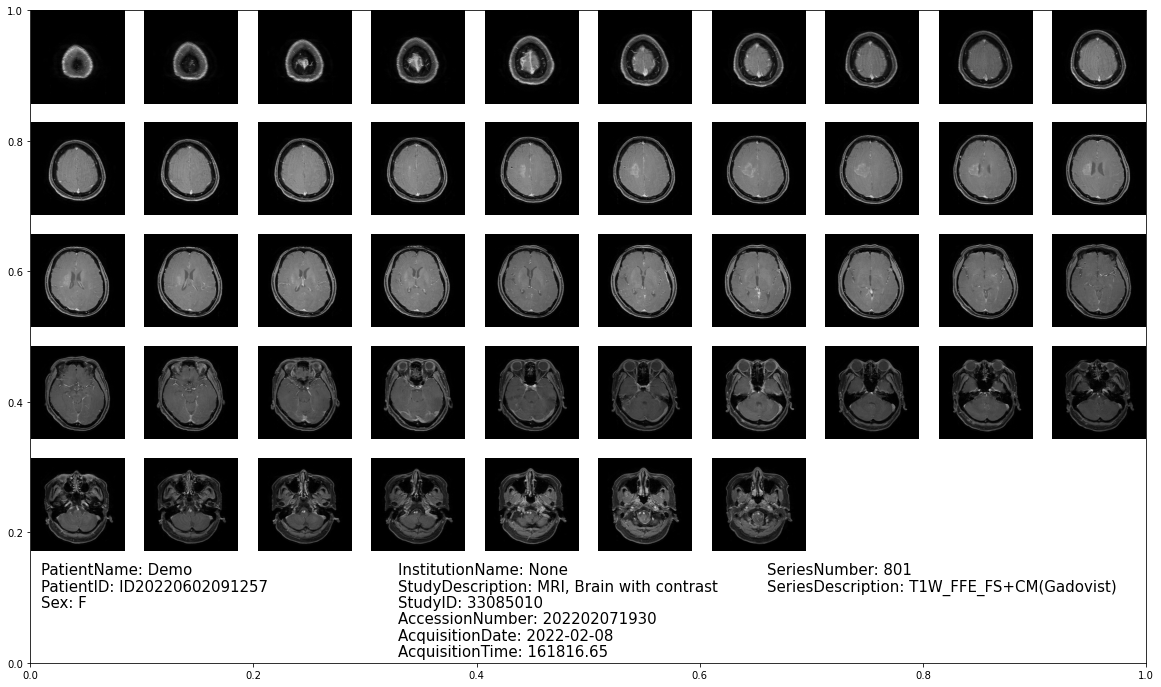

In [6]:
#draw images
drawCategorizedImages('002/', dict, fontsize=15, fontfamily='DejaVu Sans')

In [7]:
#categorize dicom files with patientID, studyID and seriesID
files = glob.glob("001/*.dcm")
dict = {}
for file in files:
    ds = dcmread(file)
    patientID = ds.PatientID
    studyID = ds.StudyID
    seriesID = ds.SeriesNumber
    if patientID in dict:
        if studyID in dict[patientID]:
            if seriesID in dict[patientID][studyID]:
                dict[patientID][studyID][seriesID].append(file)
            else:
                dict[patientID][studyID][seriesID] = [file]
        else:
            dict[patientID][studyID] = {seriesID:[file]}
    else:
        dict[patientID] = {studyID:{seriesID:[file]}}

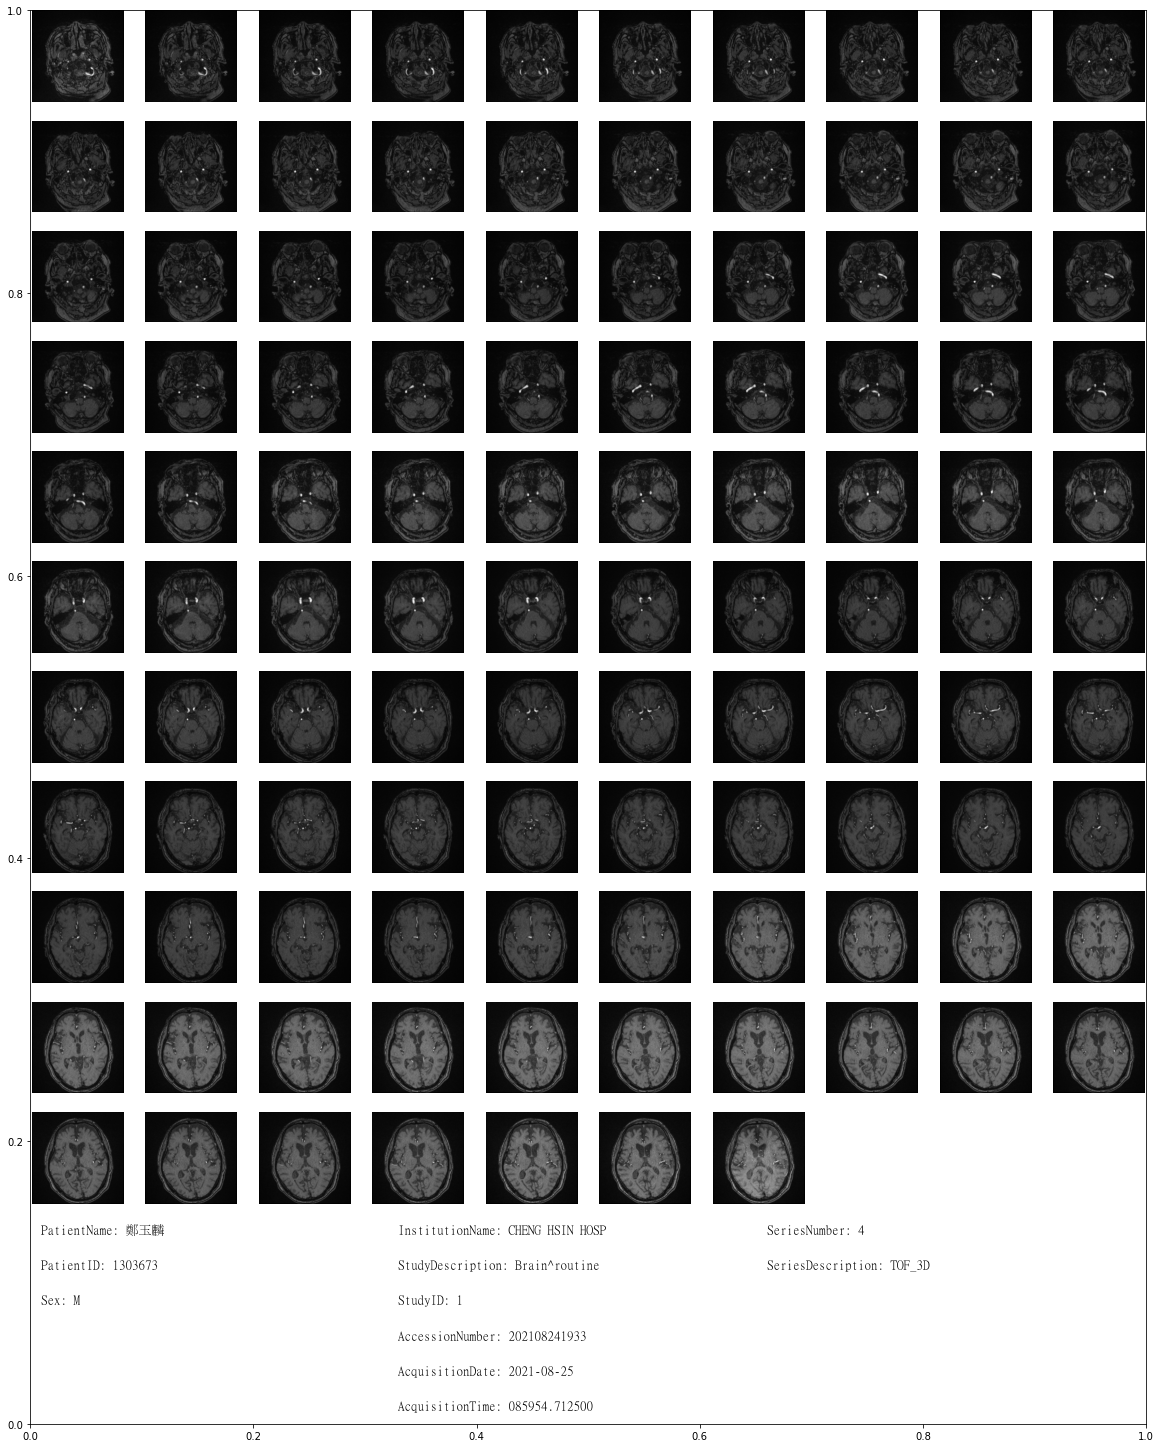

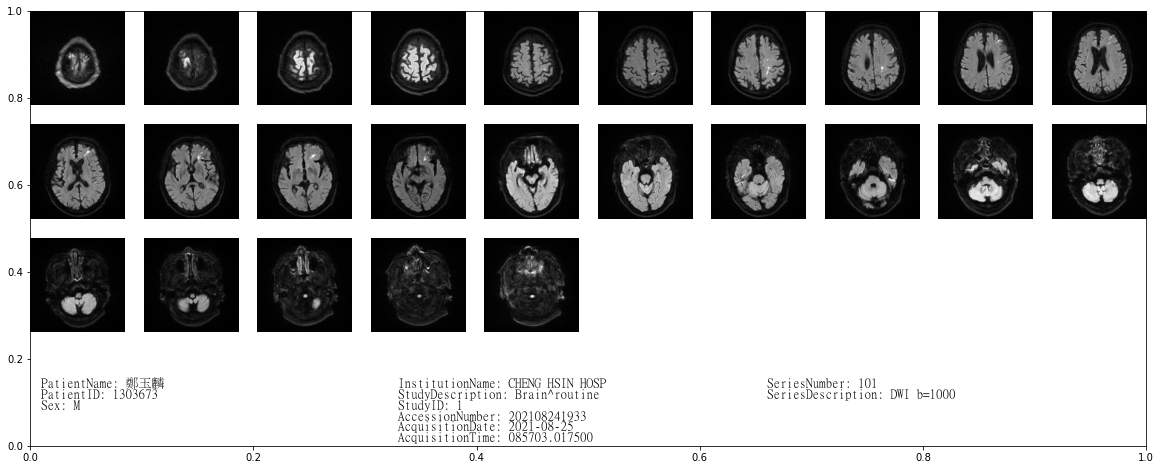

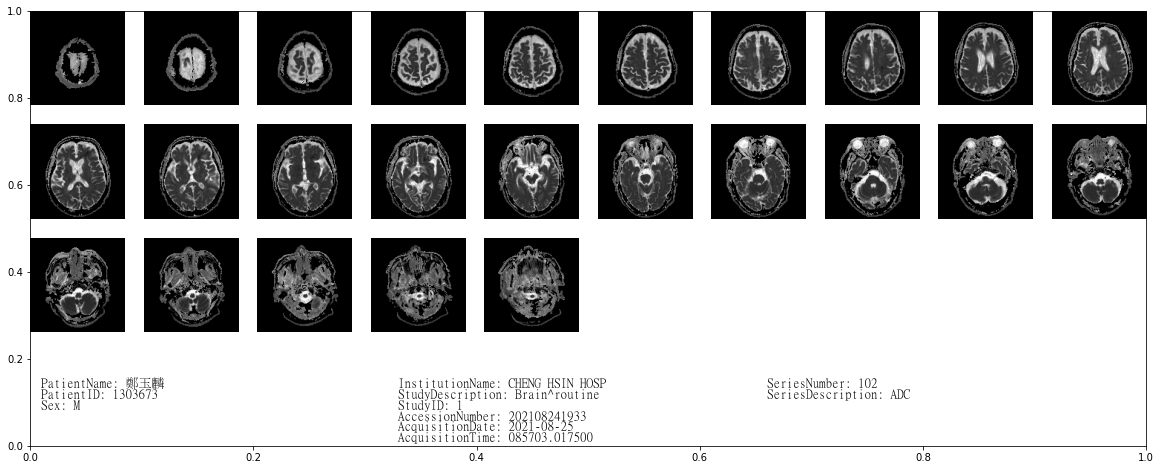

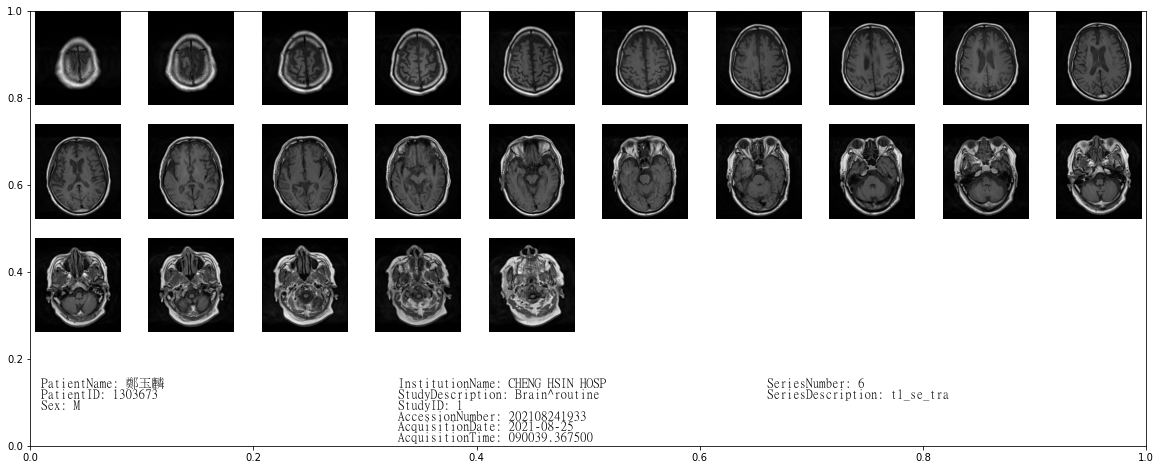

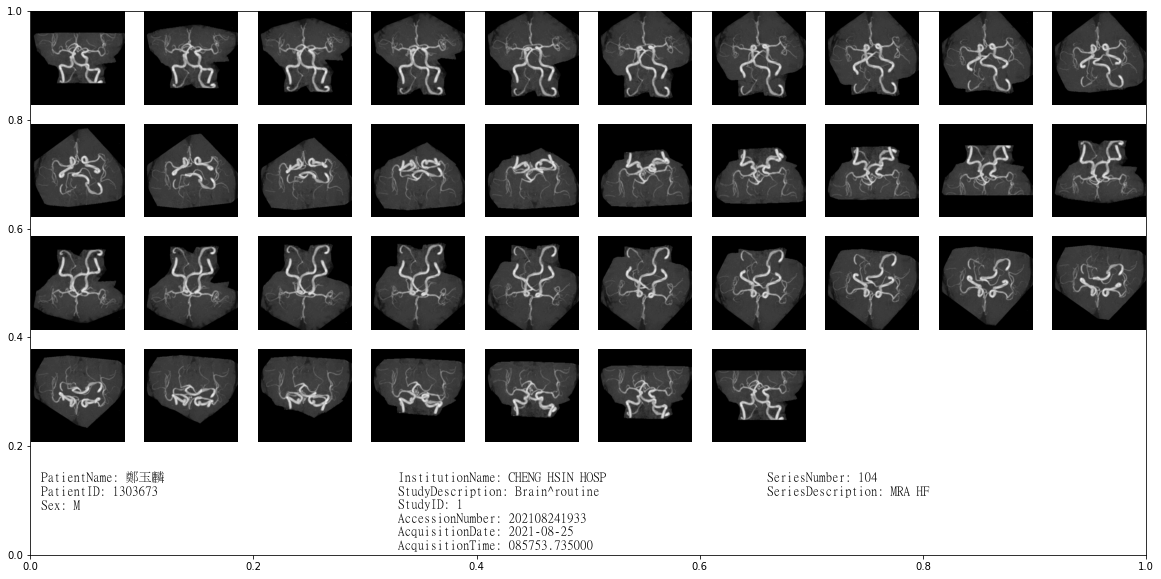

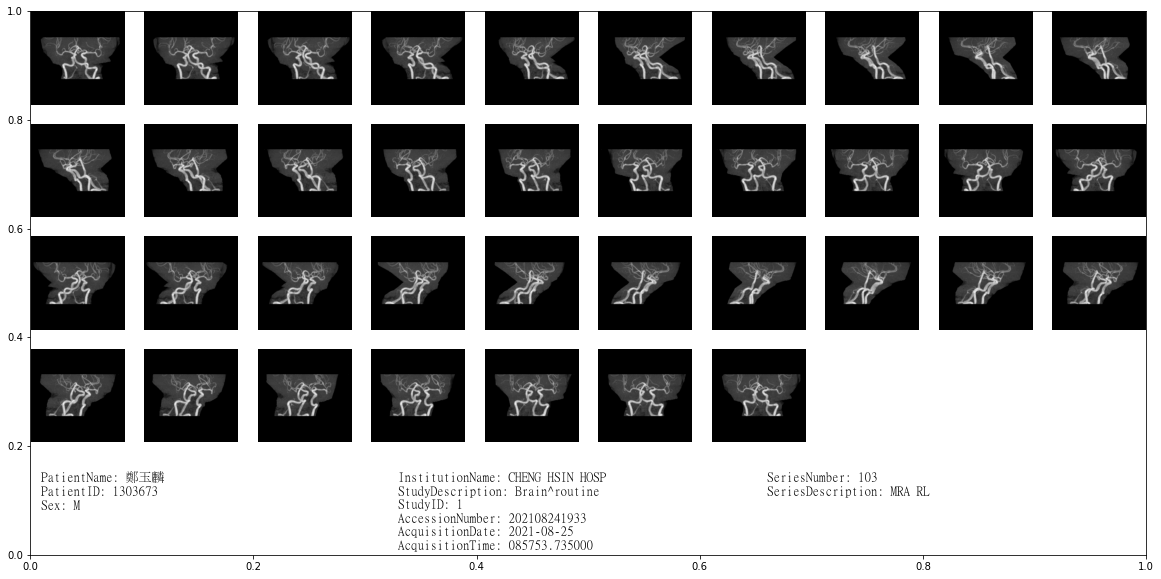

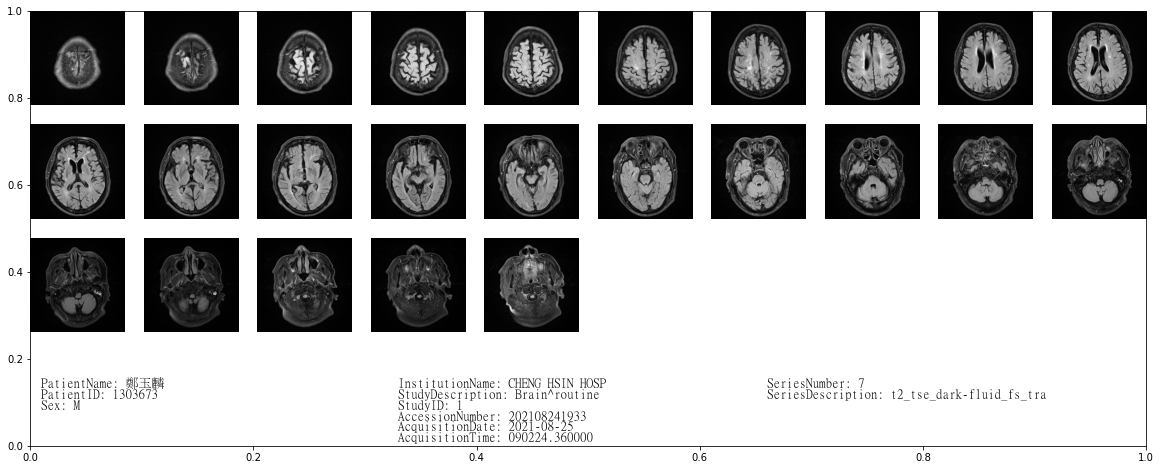

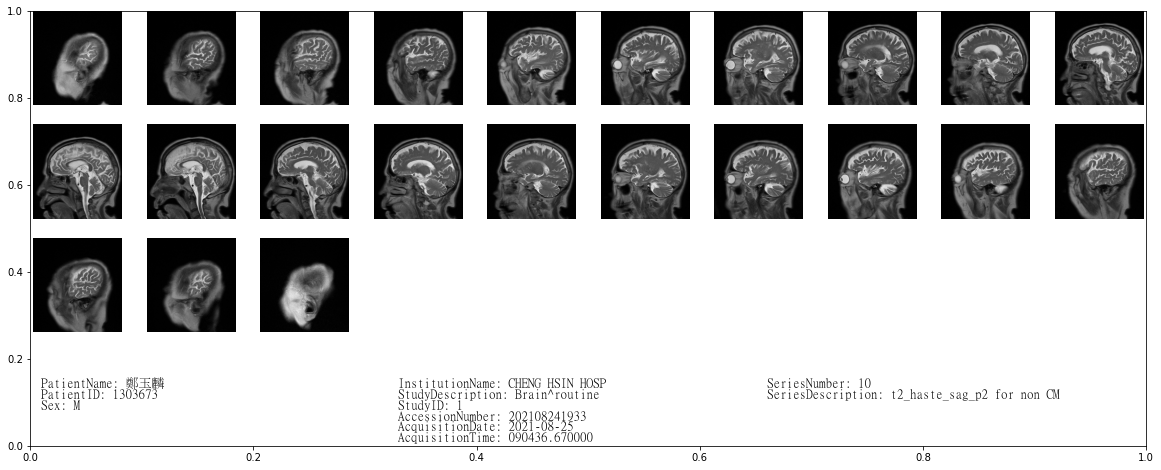

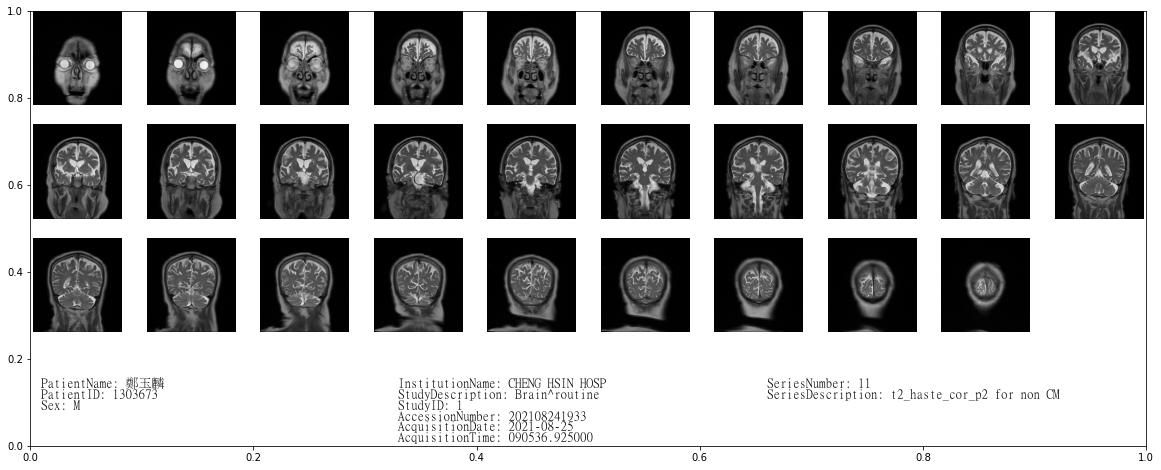

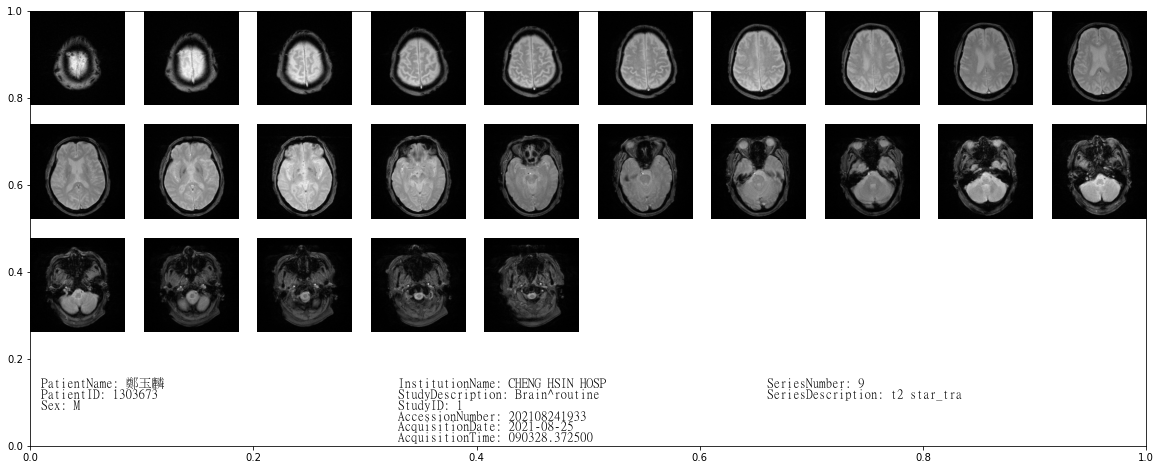

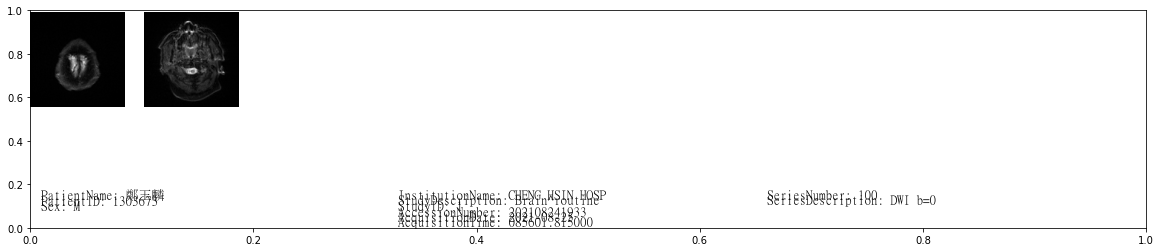

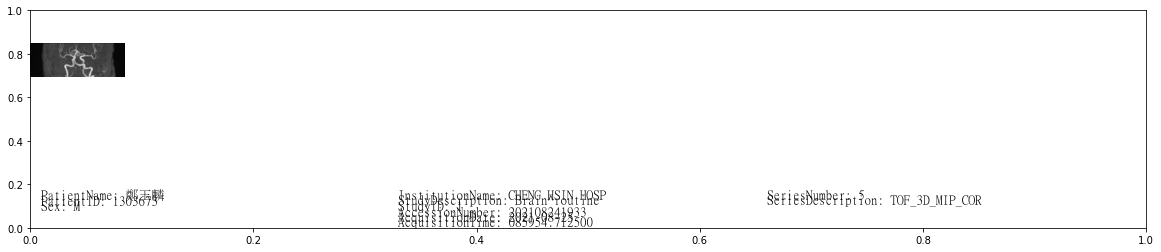

In [8]:
#draw images
drawCategorizedImages('', dict, fontsize=13)